# **В этом ноутбуке мы сгенерируем симуляцию черной дыры**

In [1]:
import scipy
import numpy
from scipy.integrate import quad
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np

Первое, что нужно реализовать, — это сингулярное интегральное уравнение, которое нам нужно.

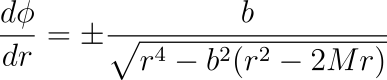

Интегральное уравнение имеет знак +/- впереди, потому что знак производной зависит от того, приближается ли свет к черной дыре или удаляется. В общем случае свет может двигаться к черной дыре, а затем отклоняться по пути к камере, так и не попав в черную дыру. В таком сценарии свет сначала приближается к дыре, «разворачивается» после достижения радиуса наибольшего сближения, а затем удаляется в бесконечность.

Радиус наибольшего сближения можно определить из наибольшего действительного корня знаменателя в уравнении. Он определяется как,

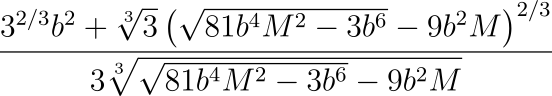

который может быть реализован в коде как,

In [2]:
def radial_potential(r, b):
  return r**4 - b**2*r**2 + 2*b**2*r


def minrs(b):
  temp = np.cbrt(b**2)*((-1 + np.sqrt(1+0j-b**2/27))**(1/3)+(-1 - np.sqrt(1+0j-b**2/27))**(1/3))
  return np.real(temp).real if np.imag(temp) < 1e-10 else 0


def d_phi_dr(r, b):
  return b / np.sqrt(radial_potential(r, b))


def phi(rs, b):
  return quad(d_phi_dr, rs, np.inf, args=(b))

Теперь мы можем начать рисовать траектории в пространстве-времени.

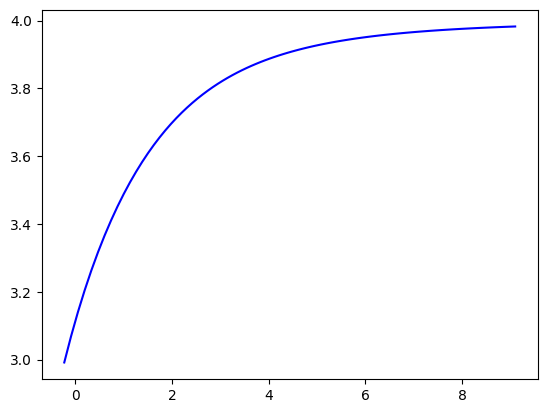

In [3]:
b = 4
steps = 100
rs = 3
rmax = 10
coords = [[step*(rmax-rs)/steps+rs, phi(step*(rmax-rs)/steps+rs, b)[0]] for step in range(0,steps)]
x_vals = list(map(lambda x: x[0]*np.cos(x[1]),coords))
y_vals = list(map(lambda x: x[0]*np.sin(x[1]),coords))
plt.plot(x_vals, y_vals, 'b')

plt.show()

У этой функции есть точка поворота, поэтому вместо этого мы выберем альтернативную параметризацию, которая позволит нам обойти ее,

In [4]:
def d_phi_dx(x, b, rt):
  return -2*b*np.abs(x) / \
    (
        (x**2+rt) * np.sqrt(-((b**2*(-2+x**2+rt)) / (x**2+rt)) + (x**2+rt)**2)
    )


def phi(xi, b):
  rt = minrs(b)
  if xi.imag != 0:
    return np.inf
  if rt == 0 and xi <0:
    return quad(d_phi_dx, np.inf, 0, args=(b,rt))
  return quad(d_phi_dx, np.inf, xi, args=(b,rt))

Отлично, теперь давайте сделаем более интересный график. Давайте поместим наш код траектории в функцию и проведем цикл по нескольким значениям b.

In [6]:
def generate_trajectory(ximin, ximax, b, steps):
  rt = minrs(b)
  coords = np.ndarray([steps,2])
  for step in range(steps):
    xi = step*(ximax - ximin)/steps + ximin
    rs = 0 if rt == 0 and xi < 0 else (xi**2 + rt)
    coords[step][0] = rs
    coords[step][1] =  phi(xi, b)[0]
  x_vals = list(map(lambda x: x[0]*numpy.cos(x[1]),coords))
  y_vals = list(map(lambda x: x[0]*numpy.sin(x[1]),coords))
  return x_vals, y_vals

Теперь мы можем запустить код и посмотреть, что произойдет.

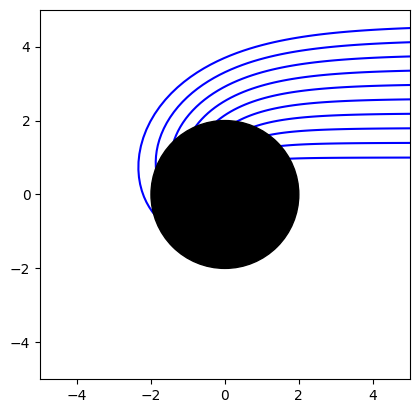

In [7]:
binit = 1
bfinal = 5
ncurves = 10

for i in range(ncurves):
  plt.plot(*generate_trajectory(1, 3, i*(bfinal-binit)/ncurves + binit, 100), 'b')


plt.xlim([-5, 5])
plt.ylim([-5, 5])
ax = plt.gca()
ax.set_aspect(1)
ax.add_patch(plt.Circle((0, 0), 2, color='k', zorder=10))
plt.show()

Теперь мы можем использовать функции вращения, которые мы определили ранее, чтобы нарисовать аккреционный диск.

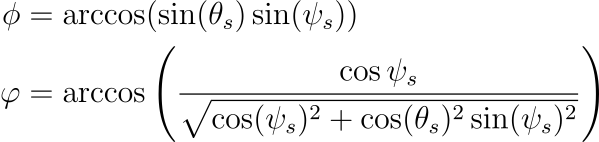

In [9]:
def psi( phi, theta ):
  return np.arccos(np.sin(theta)*np.sin(phi))


def varphi( phi, theta ):
  return np.arccos(np.cos(phi)/(np. sqrt(np.cos(phi)** 2 + np.cos(theta)** 2 *np.sin(phi)** 2 )))

Сложность заключается в том, что заданная траектория может пересекать аккреционный диск любое количество раз. Таким образом, вы можете построить изображение, связанное с 0 числом пересечений, 1 или более. Получение этого эффекта сводится к добавлению дополнительного π для каждого пересечения.

Собирая все воедино для черной дыры, аккреционный диск которой наблюдается под углом наклона около 85⁰, мы имеем:

<ipython-input-10-b8c26cccb382>:12: RuntimeWarning: invalid value encountered in sqrt
  psivals2 = np.array([[phi(np.sqrt(rs-minrs(b)), b)[0],b] for b in np.linspace(0,bmax,num=steps)])
<ipython-input-4-920b5795d767>:4: RuntimeWarning: invalid value encountered in scalar divide
  (x**2+rt) * np.sqrt(-((b**2*(-2+x**2+rt)) / (x**2+rt)) + (x**2+rt)**2)
<ipython-input-4-920b5795d767>:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(d_phi_dx, np.inf, xi, args=(b,rt))
<ipython-input-10-b8c26cccb382>:13: RuntimeWarning: invalid value encountered in sqrt
  psivals3 = np.array([[phi(-np.sqrt(rs-minrs(b)), b)[0],b] for b in np.linspace(3,bmax,num=steps)])
<ipython-input-10-b8c26cccb382>:26: RuntimeWarning: invalid value encountered in sqrt
  psivals2 = np.array([[phi(-np.sqrt(rs-minrs(b)), b)[0],b] for b in np.linspace(5,bmax,num=steps)])
<ipython-input-10-b8c26c

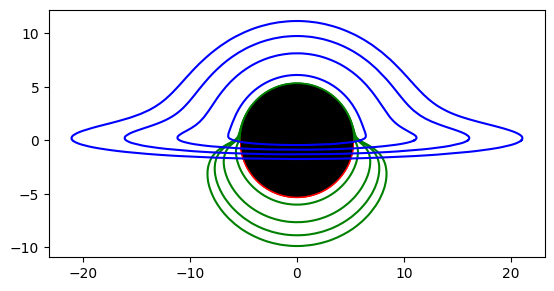

In [10]:
steps = 2000
theta = 85*np.pi/180
rmin = 5
rmax = 25
rsteps = 5
#n = 0
for rs in range(rmin, rmax, rsteps):
  bmax = np.sqrt(rs**3/ (rs-2))+1
  phivals = np.linspace(0.0001*np.pi,2*np.pi*0.9999,num=steps)
  varphivals = np.array([np.pi if phi >= np.pi else 0 for phi in phivals])+np.arccos(np.sign(np.pi-phivals)*np.cos(phivals)/np.sqrt(np.cos(phivals)**2 +np.sin(phivals)**2*np.cos(theta)**2))
  psivals1 = np.array([psi(phi, theta) for phi in phivals])
  psivals2 = np.array([[phi(np.sqrt(rs-minrs(b)), b)[0],b] for b in np.linspace(0,bmax,num=steps)])
  psivals3 = np.array([[phi(-np.sqrt(rs-minrs(b)), b)[0],b] for b in np.linspace(3,bmax,num=steps)])
  bvals = np.array([min([min(psivals2, key=lambda x:abs(x[0]-psi)), min(psivals3, key=lambda x:abs(x[0]-psi))], key=lambda x:abs(x[0]-psi ))[1] for psi in psivals1])
  alphavals = (bvals) * np.cos(varphivals)
  betavals = -(bvals) * np.sin(varphivals)
  plt.plot(alphavals, betavals, 'b', zorder=9)


#n=1
for rs in range(rmin, rmax, rsteps):
  bmax = np.sqrt(rs**3/ (rs-2))+1
  phivals = np.linspace(0.001*np.pi,2*np.pi*0.999,num=steps)
  varphivals = np.array([np.pi if phi >= np.pi else 0 for phi in phivals])+np.arccos(np.sign(np.pi-phivals)*np.cos(phivals)/np.sqrt(np.cos(phivals)**2 +np.sin(phivals)**2*np.cos(theta)**2))
  psivals1 = np.pi + np.array([psi(phi, theta) for phi in phivals]) # n=1 is pi degrees away from n=0
  psivals2 = np.array([[phi(-np.sqrt(rs-minrs(b)), b)[0],b] for b in np.linspace(5,bmax,num=steps)])
  psivals3 = np.array([[phi(-np.sqrt(rs-minrs(b)), b)[0],b] for b in np.linspace(5,bmax,num=steps)])
  bvals = np.array([min([min(psivals2, key=lambda x:abs(x[0]-psi)), min(psivals3, key=lambda x:abs(x[0]-psi))], key=lambda x:abs(x[0]-psi ))[1] for psi in psivals1])
  alphavals = (bvals) * np.cos(varphivals)
  betavals = -(bvals) * np.sin(varphivals)
  plt.plot(alphavals, betavals, 'g', zorder=8)


#n=2
for rs in range(rmin, rmax, rsteps):
  bmax = np.sqrt(rs**3/ (rs-2))+1
  phivals = np.linspace(0.001*np.pi,2*np.pi*0.999,num=steps)
  varphivals = np.array([np.pi if phi >= np.pi else 0 for phi in phivals])+np.arccos(np.sign(np.pi-phivals)*np.cos(phivals)/np.sqrt(np.cos(phivals)**2 +np.sin(phivals)**2*np.cos(theta)**2))
  psivals1 = 2*np.pi + np.array([psi(phi, theta) for phi in phivals]) # n=2 is 2pi degrees away from n=0
  psivals2 = np.array([[phi(-np.sqrt(rs-minrs(b)), b)[0],b] for b in np.linspace(5,bmax,num=steps)])
  psivals3 = np.array([[phi(-np.sqrt(rs-minrs(b)), b)[0],b] for b in np.linspace(5,bmax,num=steps)])
  bvals = np.array([min([min(psivals2, key=lambda x:abs(x[0]-psi)), min(psivals3, key=lambda x:abs(x[0]-psi))], key=lambda x:abs(x[0]-psi ))[1] for psi in psivals1])
  alphavals = (bvals) * np.cos(varphivals)
  betavals = -(bvals) * np.sin(varphivals)
  plt.plot(alphavals, betavals, 'r', zorder=7)


ax = plt.gca()
ax.add_patch(plt.Circle((0, 0), np.sqrt(27), color='k', zorder=8))


ax.set_aspect(1)
plt.show()

**voila!**